# Predicting Graduation Rates at 4 Year Universities

<ul><li>My First Data Science Portfolio Project</li></ul>

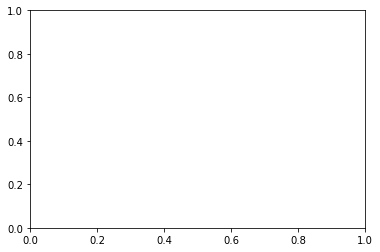

In [1]:
import cbell as cb

In [2]:
import pandas as pd
import numpy as np

#conda install -c conda-forge cufflinks-py
#conda install plotly
import ipywidgets as wg
from IPython.display import display
import pandas as pd 
import numpy as np
import cufflinks as cf
import chart_studio.plotly as py

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import inspect
import seaborn as sns
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
pd.options.display.max_columns = 200
pd.options.display.max_rows = 272

from joblib import dump, load
from Logger import RegressionLogger, FuncTransformer, ColSelect

In [3]:
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")
df.drop("Unnamed: 0",axis=1, inplace=True)
df.drop(["City location of institution (HD2019)", "Institution Name"], axis=1, inplace=True)
X = df.iloc[:, :-14]
y = df.iloc[:,-14]
X = pd.get_dummies(X, drop_first=True)

In [4]:
model_log = load("data/model_logging.joblib")

In [5]:
# from joblib import dump, load
model = model_log[4]['model']

In [6]:
# load in feature engineered features
X_fe = load("data/features.joblib")

In [7]:
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")

In [8]:
df.filter(regex='Grad').describe().loc['mean'].sort_values().index

Index(['Graduation rate  Black  non-Hispanic (DRVGR2019)',
       'Graduation rate  American Indian or Alaska Native (DRVGR2019)',
       'Graduation rate  Hispanic (DRVGR2019)',
       'Graduation rate  men (DRVGR2019)',
       'Graduation rate  two or more races (DRVGR2019)',
       'Graduation rate  Native Hawaiian or Other Pacific Islander (DRVGR2019)',
       'Graduation rate  Race/ethnicity unknown (DRVGR2019)',
       'Graduation rate  total cohort (DRVGR2019)',
       'Graduation rate  White  non-Hispanic (DRVGR2019)',
       'Graduation rate  women (DRVGR2019)',
       'Graduation rate  Asian/Native Hawaiian/Other Pacific Islander (DRVGR2019)',
       'Graduation rate  Nonresident alien (DRVGR2019)',
       'Graduation rate  Asian (DRVGR2019)'],
      dtype='object')

In [9]:
means = df.filter(regex='Grad').describe().loc['mean'].sort_values().to_numpy()
cols = ['Black', 'American Indian', 'Hispanic', 'men', 'two or more races', 
        'Native Hawaiian', 'unknown', 'total cohort', 'White',
        'women', 'Asian/Native Hawaiian', 'Nonresident alien', 'Asian']
#cols = cols.str.replace("Graduation rate", "")
#cols = cols.str.replace("DRVGR2019", "")
#cols = cols.str.replace("Other Pacific Islander", "")
fig = go.Figure()
_ = fig.add_trace(go.Bar(
    x=cols, y=means, text=np.round(means, 2)
))
_ = fig.update_layout(
    title='Mean Graudation Rates',
    xaxis={
        'title': "Gender/Race"
    },
    yaxis = {
        'title': "Mean Graduation Rate"
    },
    height = 600
)

In [10]:
fig.show()

<ul><li>4 year institutions</li></ul>

<ul><li>2019 Cohort</li></ul>

<ul><li>6 year Graduation Rates</li></ul>

# Problem Statement

## <ul><li>Problem</li></ul>
University X is facing pressure from the community claiming that the university is underperforming particularly with students of color. The University needs to respond to the community with a data backed explanation for their performance along with a data driven plan to improve outcome measures (Graduation Rates)

## <ul><li>Source of Data</li></ul>

The Data Science team has access to the free publicly available Ipeds Data Center, which has data about all 4-year public and private institutions.

<a src='https://nces.ed.gov/ipeds/use-the-data'>Ipeds Data Center</a>

In [11]:
# Reset Our Data Frame
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")
df.drop("Unnamed: 0",axis=1, inplace=True)

## Overview Of Features

### Numeric Features
<ul>
    <li>Revenues and Expenses</li>
    <li>Price of School</li>
    <li>Admissions Test Scores</li>
    <li>Staff Diversity</li>
    <li>Enrollment Diversity</li>
    <li>Student-to-Faculty Ratio</li>
</ul>

### Categorical Features
<ul>
    <li>State</li>
    <li>Sector</li>
    <li>Carnegie Classification</li>
    <li>HBCU</li>
</ul>

# Looking at Graduation Rates By Sector

In [12]:
sector = df.filter(regex="Sector").columns[0]
black = df.filter(regex="Grad.*Black").columns[0]
total = df.filter(regex="Grad").columns[0]

In [13]:
all_sectors = df[sector].unique()

In [14]:
sector_group = df.groupby(by=sector)

In [15]:
grad_rate_by_sector = sector_group.agg('mean').sort_values(by=black)[[black, total]]

In [16]:
grad_rate_by_sector.drop(['Public, 2-year', 'isMissing', 'Private not-for-profit, 2-year', 
                          'Private for-profit, 2-year', 'Private for-profit, less-than 2-year'],
                         inplace=True)

In [17]:
all_sectors[1]

'Private not-for-profit, 4-year or above'

In [18]:
not_for_profit = sector_group.get_group(all_sectors[2])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(not_for_profit, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error1 = (ci[1] - ci[0]) / 2

In [19]:
public_4black = sector_group.get_group(all_sectors[2])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(public_4black, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error2 = (ci[1] - ci[0]) / 2

In [20]:
private_for_profit = sector_group.get_group(all_sectors[3])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(private_for_profit, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error3 = (ci[1] - ci[0]) / 2

In [21]:
fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_by_sector.index, y=grad_rate_by_sector[total], 
               text=np.round(grad_rate_by_sector[total], 1), name="Total Cohort"),
        go.Bar(x=grad_rate_by_sector.index, y=grad_rate_by_sector[black], 
               text=np.round(grad_rate_by_sector[black], 1), name="African American",
               error_y=dict(type='data', array=[sector_error1, sector_error2, sector_error3])),
        
    ]
)

_ = fig.update_layout(
    title="Mean Graduation Rates By Sector of Institution",
    xaxis={
        'title': "Sector"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    }
)

In [22]:
fig.show()

# Graduation Rates by State

In [23]:
state = df.filter(regex="State").columns[0]
all_states = df[state].unique()

In [24]:
state_group = df.groupby(by=state)

In [25]:
grad_rate_by_state = state_group.agg('mean').sort_values(by=black)[[black, total]].dropna()

In [26]:
state_yblack = grad_rate_by_state[black].to_numpy()[0:51:10]
state_y = grad_rate_by_state[total].to_numpy()[0:51:10]

fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_by_state.index[0:51:10], y=state_y, 
               text=np.round(state_y, 1), name="Total Cohort"),
        go.Bar(x=grad_rate_by_state.index[0:51:10], y= state_yblack, 
               text=np.round(state_yblack, 1), name="African American"),
        
    ]
)

_ = fig.update_layout(
    title="Mean Graduation Rates By State",
    xaxis={
        'title': "State"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    }
)
fig.show()

# Graduation Rates (HBCU vs Non HBCU)

In [27]:
hbcu = df.filter(regex="Historically").columns[0]
hbcu_group = df.groupby(by=hbcu)
grad_rate_hbcu = hbcu_group.agg('mean').sort_values(by=black)[[black, total]]

In [28]:
grad_rate_hbcu = grad_rate_hbcu.drop("isMissing")

In [29]:
fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_hbcu.index, y=grad_rate_hbcu[total], 
               text=np.round(grad_rate_hbcu[total], 1), name="Total Cohort"),
        go.Bar(x=grad_rate_hbcu.index, y=grad_rate_hbcu[black], 
               text=np.round(grad_rate_hbcu[black], 1), name="African American"),
    ]
)

_ = fig.update_layout(
    title="Mean Graduation Rates For Historically Black Colleges and Universities",
    xaxis={
        'title': "Is_HBCU"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    },
    
)
fig.show()

## Whats The Problem With These Comparisons?

# Multivariate Plots

In [30]:
hbcu_df = df[df[hbcu] == 'Yes']
hwcu_df = df[df[hbcu] == 'No']
missing = df[df[hbcu] == 'isMissing']

## Graduation Rates vs By Price

In [31]:
price = df.filter(regex='price').columns[2]
test_score = df.filter(regex='Composite').columns[0]

In [32]:
fig = px.scatter(
    df, x=price, y=total, color=hbcu, title="HBCU Graduation Rates Controlling for Price",
    hover_name='Institution Name'
)

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

## Graduation Rates vs ACT Scores

In [33]:
fig = px.scatter(
    df, x=test_score, y=total, color=hbcu, 
    title="HBCU Graduation Rates Controlling for Admissions Test Scores (ACT)",
    hover_name='Institution Name'
)

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

## A First Look At Feature Engineering

### All plots from here on out are using a subset of the data (training data)

### Create transformations only using training data and apply them to the entire data set

In [34]:
fig = px.scatter(
    x=df['Core_Revenues'], y=df[total], color=df[hbcu], title="HBCU Graduation Rates vs Core Revenues",
    hover_name=df['Institution Name']
)

fig.update_layout(
    title="HBCU Graduation Rates vs Core Revenues",
    xaxis_title="Core Revenues",
    yaxis_title="Graduation Rate",
    legend_title="Legend",
    height=450,
    width=550,
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [35]:
fig = px.scatter(
    x=np.log(df['Core_Expenses']), y=df[total], color=df[hbcu], title="HBCU Graduation Rates vs Core Revenues",
    hover_name=df['Institution Name']
)

fig.update_layout(
    title="HBCU Graduation Rates vs Log Core Revenues",
    xaxis_title="Log Core Revenues",
    yaxis_title="Graduation Rate",
    legend_title="Legend",
    height=450,
    width=550,
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [36]:
x_train, x_test, y_train, y_test, sample_x, sample_y = load("objects/holdout_total.joblib")

In [37]:
sample_x

,Core_Revenues,Tuition_And_Fees,Government_Grants,Private_Gifts,Investment_Return,Sales_And_Services,Other_Revenues,Tuition_And_Fees_As_Dollar_Amount,Government_Grants_As_Dollar_Amount,Private_Gifts_As_Dollar_Amount,Investment_Return_As_Dollar_Amount,Sales_And_Services_As_Dollar_Amount,Other_Revenues_As_Dollar_Amount,Core_Expenses,Instruction_Expenses,Research_Expenses,Public_Service_Expenses,Academic_Support_Expenses,Student_Service_Expenses,Institutional_Support_Expenses,Other_Core_Expenses,Instruction_Expenses_As_Dollar_Amount,Research_Expenses_As_Dollar_Amount,Public_Service_Expenses_As_Dollar_Amount,Academic_Support_Expenses_As_Dollar_Amount,Student_Service_Expenses_As_Dollar_Amount,Institutional_Support_Expenses_As_Dollar_Amount,Other_Core_Expenses_As_Dollar_Amount,Grand total instructional_staff,Grand total men instructional_staff,Grand total women instructional_staff,American Indian or Alaska Native total instructional_staff,American Indian or Alaska Native men instructional_staff,American Indian or Alaska Native women instructional_staff,Asian total instructional_staff,Asian men instructional_staff,Asian women instructional_staff,Black or African American total instructional_staff,Black or African American men instructional_staff,Black or African American women instructional_staff,Hispanic or Latino total instructional_staff,Hispanic or Latino men instructional_staff,Hispanic or Latino women instructional_staff,Native Hawaiian or Other Pacific Islander total instructional_staff,Native Hawaiian or Other Pacific Islander men instructional_staff,Native Hawaiian or Other Pacific Islander women instructional_staff,White total instructional_staff,White men instructional_staff,White women instructional_staff,Two or more races total instructional_staff,Two or more races men instructional_staff,Two or more races women instructional_staff,Race/ethnicity unknown total instructional_staff,Race/ethnicity unknown men instructional_staff,Race/ethnicity unknown women instructional_staff,Nonresident alien total instructional_staff,Nonresident alien men instructional_staff,Nonresident alien women instructional_staff,Grand total men instructional_staff_as_percentage,Grand total women instructional_staff_as_percentage,American Indian or Alaska Native total instructional_staff_as_percentage,American Indian or Alaska Native men instructional_staff_as_percentage,American Indian or Alaska Native women instructional_staff_as_percentage,Asian total instructional_staff_as_percentage,Asian men instructional_staff_as_percentage,Asian women instructional_staff_as_percentage,Black or African American total instructional_staff_as_percentage,Black or African American men instructional_staff_as_percentage,Black or African American women instructional_staff_as_percentage,Hispanic or Latino total instructional_staff_as_percentage,Hispanic or Latino men instructional_staff_as_percentage,Hispanic or Latino women instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander total instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander men instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander women instructional_staff_as_percentage,White total instructional_staff_as_percentage,White men instructional_staff_as_percentage,White women instructional_staff_as_percentage,Two or more races total instructional_staff_as_percentage,Two or more races men instructional_staff_as_percentage,Two or more races women instructional_staff_as_percentage,Race/ethnicity unknown total instructional_staff_as_percentage,Race/ethnicity unknown men instructional_staff_as_percentage,Race/ethnicity unknown women instructional_staff_as_percentage,Nonresident alien total instructional_staff_as_percentage,Nonresident alien men instructional_staff_as_percentage,Nonresident alien women instructional_staff_as_percentage,Percent of full-time first-time undergraduates awarded any financial aid (SFA1819),Percent of full-time first-time und

In [38]:
x_train.head()

,Core_Revenues,Tuition_And_Fees,Government_Grants,Private_Gifts,Investment_Return,Sales_And_Services,Other_Revenues,Tuition_And_Fees_As_Dollar_Amount,Government_Grants_As_Dollar_Amount,Private_Gifts_As_Dollar_Amount,Investment_Return_As_Dollar_Amount,Sales_And_Services_As_Dollar_Amount,Other_Revenues_As_Dollar_Amount,Core_Expenses,Instruction_Expenses,Research_Expenses,Public_Service_Expenses,Academic_Support_Expenses,Student_Service_Expenses,Institutional_Support_Expenses,Other_Core_Expenses,Instruction_Expenses_As_Dollar_Amount,Research_Expenses_As_Dollar_Amount,Public_Service_Expenses_As_Dollar_Amount,Academic_Support_Expenses_As_Dollar_Amount,Student_Service_Expenses_As_Dollar_Amount,Institutional_Support_Expenses_As_Dollar_Amount,Other_Core_Expenses_As_Dollar_Amount,Grand total instructional_staff,Grand total men instructional_staff,Grand total women instructional_staff,American Indian or Alaska Native total instructional_staff,American Indian or Alaska Native men instructional_staff,American Indian or Alaska Native women instructional_staff,Asian total instructional_staff,Asian men instructional_staff,Asian women instructional_staff,Black or African American total instructional_staff,Black or African American men instructional_staff,Black or African American women instructional_staff,Hispanic or Latino total instructional_staff,Hispanic or Latino men instructional_staff,Hispanic or Latino women instructional_staff,Native Hawaiian or Other Pacific Islander total instructional_staff,Native Hawaiian or Other Pacific Islander men instructional_staff,Native Hawaiian or Other Pacific Islander women instructional_staff,White total instructional_staff,White men instructional_staff,White women instructional_staff,Two or more races total instructional_staff,Two or more races men instructional_staff,Two or more races women instructional_staff,Race/ethnicity unknown total instructional_staff,Race/ethnicity unknown men instructional_staff,Race/ethnicity unknown women instructional_staff,Nonresident alien total instructional_staff,Nonresident alien men instructional_staff,Nonresident alien women instructional_staff,Grand total men instructional_staff_as_percentage,Grand total women instructional_staff_as_percentage,American Indian or Alaska Native total instructional_staff_as_percentage,American Indian or Alaska Native men instructional_staff_as_percentage,American Indian or Alaska Native women instructional_staff_as_percentage,Asian total instructional_staff_as_percentage,Asian men instructional_staff_as_percentage,Asian women instructional_staff_as_percentage,Black or African American total instructional_staff_as_percentage,Black or African American men instructional_staff_as_percentage,Black or African American women instructional_staff_as_percentage,Hispanic or Latino total instructional_staff_as_percentage,Hispanic or Latino men instructional_staff_as_percentage,Hispanic or Latino women instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander total instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander men instructional_staff_as_percentage,Native Hawaiian or Other Pacific Islander women instructional_staff_as_percentage,White total instructional_staff_as_percentage,White men instructional_staff_as_percentage,White women instructional_staff_as_percentage,Two or more races total instructional_staff_as_percentage,Two or more races men instructional_staff_as_percentage,Two or more races women instructional_staff_as_percentage,Race/ethnicity unknown total instructional_staff_as_percentage,Race/ethnicity unknown men instructional_staff_as_percentage,Race/ethnicity unknown women instructional_staff_as_percentage,Nonresident alien total instructional_staff_as_percentage,Nonresident alien men instructional_staff_as_percentage,Nonresident alien women instructional_staff_as_percentage,Percent of full-time first-time undergraduates awarded any financial aid (SFA1819),Percent of full-time first-time und

## Other Log Transformations

In [69]:
fig = px.scatter(
    x=x_train['Academic_Support_Expenses_As_Dollar_Amount'], y=y_train, title="HBCU Graduation Rates vs Core Revenues",
)

fig.update_layout(
    title="Graduation Rates vs Academic_Support_Expenses_As_Dollar_Amount",
    xaxis_title="Academic_Support_Expenses_As_Dollar_Amount",
    yaxis_title="Graduation Rate",
    legend_title="Legend",
    height=450,
    width=550,
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [68]:
fig = px.scatter(
    x=x_train['Institutional_Support_Expenses_As_Dollar_Amount'], y=y_train, title="HBCU Graduation Rates vs Core Revenues",
)

fig.update_layout(
    title="Graduation Rates vs Institutional_Support ($)",
    xaxis_title="Institutional_Support_Expenses_As_Dollar_Amount",
    yaxis_title="Graduation Rate",
    legend_title="Legend",
    height=450,
    width=550,
    font=dict(
        family="Courier New, monospace",
        size=12,
    )
)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [41]:
log_list = x_train.filter(regex="(Log)(.*)(Amount)$").columns

In [42]:
coefs = model['classifier'].coef_
feature_names = load("data/feature_names.joblib")
final_coefs = sorted(list(zip(feature_names, coefs)), key= lambda x: np.abs(x[1]))
coef_dict = {k: v for k, v in sorted(dict(zip(feature_names, coefs)).items(), key= lambda x: x[1])}

In [43]:
best = final_coefs[-11:]
best = sorted(best, key=lambda x: x[1])

## Initial Model Coefficients

In [44]:
fig = make_subplots(rows=1, cols=1, subplot_titles=["Model Coeficients"])

_ = fig.add_trace(
    go.Bar(x=[i[1] for i in best], y=[i[0] for i in best], 
           orientation='h', text=[round(i[1], 2) for i in best]),
    1, 1)

_ = fig.update_yaxes(
    tickangle = 10
)
fig.show()

## Interpreting Coefficients With Numbers

### Using inverse transform: a one init Increase in log revenues is 18.100074082796795 

### Therefore a 72,570,864.4257857 increase in other revenues will increase the projected graduation rates for school X to increase by 4.29%

In [45]:
# Getting Coefficient Interpretation
preprocess = model['preprocessing'].transformer_list[0][1] # Getting float preprocessing steps

# preprocess features the with the same steps as our pipeline
data = preprocess.fit_transform(X_fe)

# Set Log_Other_Revenues to 1 Unit
transformed_df = pd.DataFrame(data, columns=X_fe.select_dtypes(include='float').columns)
transformed_df['Log_Other_Revenues_As_Dollar_Amount'] = 1

# Inverse transform the preprocessed data
inverse_data = preprocess['Scale'].inverse_transform(transformed_df)
inverse_df = pd.DataFrame(inverse_data, columns=X_fe.select_dtypes(include='float').columns)

In [46]:
# View what a one unit increase in log other revenues realy means
new_line = '/n'
log_amount = inverse_df['Log_Other_Revenues_As_Dollar_Amount'].iloc[0]

f'A One Unit Increase in Log_Revenues is {log_amount}, therefore a {np.exp(log_amount)}'\
' increase in other revenues will increase the projected graduation rates for school X to increase' \
' by 4.29%'

'A One Unit Increase in Log_Revenues is 18.100074082796795, therefore a 72570864.4257857 increase in other revenues will increase the projected graduation rates for school X to increase by 4.29%'

# Model Performance 

In [47]:
model = model_log[4]['model']

In [48]:
pd.DataFrame(model_log[4], index=[0])

,Imputer,model_name,model,alpha,l1_ratio,rsquared,rmse,mae,train_rsquared,train_rmse,train_mae,notes
0,KNNImputer,Elastic Net,"(FeatureUnion(transformer_list=[('numeric',\n ...",0.3,0.8,0.536707,14.015952,9.509088,0.634621,13.306718,9.332271,Tuned Elstic Net Model


## Data Science Insights

In [49]:
# pip install joblib 
# conda install -c anaconda joblib 
from joblib import dump, load
model_log = load("data/model_logging.joblib")

In [50]:
model_log_df = pd.DataFrame().from_dict(model_log)
model_log_df.fillna("", inplace=True)
model_log_df.iloc[4][['model_name', 'mae']]

model_name    Elastic Net
mae              9.509088
Name: 4, dtype: object

In [51]:
model_log = load("data/model_logging.joblib")

In [52]:
params = {}
logger = RegressionLogger(params)
logger.train_update(model, X_fe, y)

## Residual Plots

In [73]:
residuals = logger.y_pred - logger.y_test
resid_data = {
    'y_test': logger.y_test,
    'Residuals':residuals,
}

fig = px.scatter(resid_data, x='y_test', y='Residuals')

_ = fig.update_layout(
    title="Lasso Regression LaResidual Plot (Observed)",
    xaxis_title="Observed Graduation Rate",
    yaxis_title="Residuals",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.show()

In [74]:
residuals = logger.y_pred - logger.y_test
resid_data = {
    'y_pred': logger.y_pred,
    'Residuals':residuals,
}
fig = px.scatter(resid_data, x='y_pred', y='Residuals')

fig.update_layout(
    title="Lasso Regression Residual Plot (predicted)",
    xaxis_title="Predicted Graduation Rate",
    yaxis_title="Residuals",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)


fig.show()

### <ul><li>Our Models tend to overpredict schools that report low graduation rates</li></ul>

### <ul><li>The Model tends to underpredict schools that report very high graduation rates</li></ul>

### Regression Towads the Mean

# Conclusion

## Overall Model Performance

In [55]:
fig = make_subplots(rows=1, cols=1, subplot_titles=["Predicted Vs Actual"])

fig.add_trace(
    go.Scatter(x=logger.y_pred, y=logger.y_test, mode='markers', name='Pred vs. Actual'),
    1, 1)

fig.add_trace(
    go.Scatter(x=np.arange(0,100,1), y=np.arange(0,100,1), mode='lines', name='100 % acc')
)

fig.update_layout(
    title="Model Performance",
    xaxis_title="Predicted Graduation Rate",
    yaxis_title="Actual Graduation Rate",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()